In [1]:
!pip install tensorflow-text==2.8.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 8.5 MB/s 


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_text as tf_text
import typing
from typing import Any,Tuple
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
use_builtins = True

In [4]:
class ShapeChecker():

  def __init__(self):
    self.shapes = {}
  
  def __call__(self,tensor,names,broadcast=True):

    if not tf.executing_eagerly():
      return

    if isinstance(names,str):
      names = (names,)
    
    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError("Rank and length of names mismatch")
    
    for i,name in enumerate(names):

      if isinstance(name,int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name,None)
      
      new_dim = shape[i]

      if broadcast and new_dim==1:
        continue
      
      if old_dim is None:
        self.shapes[name] = new_dim
        continue
      
      if old_dim != new_dim:
        raise ValueError("\nDimension mismatch")

In [5]:
import pathlib

path_to_zip = tf.keras.utils.get_file("spa-eng.zip",
                                      origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
                                      extract=True)
path = pathlib.Path(path_to_zip).parent/"spa-eng/spa.txt"

2654208/2638744 [==============================] - 0s 0us/step


In [6]:
def load_data(path):
  text = path.read_text(encoding="utf-8")
  lines = text.splitlines()
  pairs = [line.split("\t") for line in lines]

  targ = [tar for (tar,inp) in pairs]
  inp = [inu for (tar,inu) in pairs]

  return inp,targ

In [7]:
inp,targ = load_data(path=path)
print(inp[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [8]:
print(targ[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [9]:
for i in tf.data.Dataset.from_tensor_slices(inp).take(2):
  print(i)

tf.Tensor(b'Ve.', shape=(), dtype=string)
tf.Tensor(b'Vete.', shape=(), dtype=string)


In [10]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((inp,targ)).shuffle(buffer_size=BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [12]:
for inp_batch,targ_batch in dataset.take(1):
  print(inp_batch[:3])
  print("\nNew language")
  print(targ_batch[:3])

tf.Tensor(
[b'Acomp\xc3\xa1\xc3\xb1anos si quieres.'
 b'Cerr\xc3\xa1 la ventana antes de ir a dormir.'
 b'Tom ten\xc3\xada la sospecha de que Mary estaba mintiendo.'], shape=(3,), dtype=string)

New language
tf.Tensor(
[b'Come along with us if you like.'
 b'Close the window before going to sleep.'
 b'Tom had a hunch that Mary was lying.'], shape=(3,), dtype=string)


In [13]:
def tf_lower_and_split_punct(text):

  text = tf_text.normalize_utf8(text,"NFKD")
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text,"[^ a-z?.!,¿]","")
  text = tf.strings.regex_replace(text,"[.?!,¿]",r" \0")
  text = tf.strings.join(["[START]",text,"[END]"],separator=" ")
  return text

In [14]:
example_text = tf.constant('¿Todavía está en casa?')
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START]  ¿todavia esta en casa ? [END]


In [15]:
max_vocab_size = 5000
input_text_processor = tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct,
                                                         max_tokens=max_vocab_size)
output_text_processor = tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct,
                                                          max_tokens=max_vocab_size)
input_text_processor.adapt(inp)
output_text_processor.adapt(targ)

In [16]:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [17]:
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [18]:
len(input_text_processor.get_vocabulary())

5000

In [19]:
inp_tokens = input_text_processor(inp_batch)

In [20]:
inp_tokens.shape

TensorShape([64, 20])

In [21]:
input_vocab = np.array(input_text_processor.get_vocabulary())
" ".join(input_vocab[inp_tokens[0].numpy()])

'[START] [UNK] si quieres . [END]              '

Text(0.5, 1.0, 'Mask')

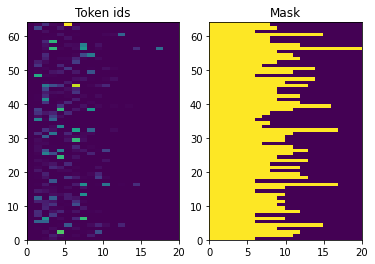

In [22]:
plt.subplot(1,2,1)
plt.pcolormesh(inp_tokens)
plt.title("Token ids")

plt.subplot(1,2,2)
plt.pcolormesh(inp_tokens!=0)
plt.title("Mask")

In [23]:
embedding_dim = 256
units = 1024

In [24]:
class Encoder(tf.keras.layers.Layer):

  def __init__(self,input_vocab_size,embedding_dim,enc_units):

    super(Encoder,self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size
    self.embedding = tf.keras.layers.Embedding(input_dim=self.input_vocab_size,
                                               output_dim=embedding_dim)
    
    self.gru = tf.keras.layers.GRU(units=enc_units,
                                   return_state=True,
                                   return_sequences=True,
                                   recurrent_initializer="glorot_uniform")
  
  def call(self,tokens,state=None):

    sc = ShapeChecker()
    sc(tokens,("batch","s"))

    vectors = self.embedding(tokens)
    sc(vectors,("batch","s","embed_dim"))

    output,state = self.gru(vectors,initial_state=state)

    sc(output,("batch","s","enc_units"))
    sc(state,("batch","enc_units"))

    return output,state

In [25]:
example_tokens = input_text_processor(inp_batch)
encoder = Encoder(enc_units=units,input_vocab_size=input_text_processor.vocabulary_size(),embedding_dim=embedding_dim)
example_enc_output,example_enc_state = encoder(inp_tokens)

print("Output shape: ",tf.shape(example_enc_output))
print("State shape: ",tf.shape(example_enc_state))
print("Input tokens shape: ",tf.shape(example_tokens))

Output shape:  tf.Tensor([  64   20 1024], shape=(3,), dtype=int32)
State shape:  tf.Tensor([  64 1024], shape=(2,), dtype=int32)
Input tokens shape:  tf.Tensor([64 20], shape=(2,), dtype=int32)


In [26]:
class BahdanauAttention(tf.keras.layers.Layer):

  def __init__(self,units):

    super(BahdanauAttention,self).__init__()
    self.W1 = tf.keras.layers.Dense(units,use_bias=False)
    self.W2 = tf.keras.layers.Dense(units,use_bias=False)
    self.attention = tf.keras.layers.AdditiveAttention()
  
  def call(self,query,value,mask):

    w1_query = self.W1(query)
    w2_key = self.W2(value)

    value_mask = mask
    query_mask = tf.ones(tf.shape(query)[:-1],dtype=bool)

    context_vector,attention_weights = self.attention(inputs=[w1_query,value,w2_key],
                                            mask=[query_mask,value_mask],
                                            return_attention_scores=True)
    
    return context_vector,attention_weights

In [27]:
class Decoder(tf.keras.layers.Layer):

  def __init__(self,output_vocab_size,embedding_dim,dec_units):

    super(Decoder,self).__init__()
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim
    self.dec_units = dec_units

    self.embedding = tf.keras.layers.Embedding(output_vocab_size,embedding_dim)
    self.gru = tf.keras.layers.GRU(dec_units,
                                   return_state=True,
                                   return_sequences=True,
                                   recurrent_initializer="glorot_uniform")
    self.attention = BahdanauAttention(dec_units)
    self.Wc = tf.keras.layers.Dense(dec_units,activation=tf.math.tanh,use_bias=False)
    self.fc = tf.keras.layers.Dense(output_vocab_size)

In [28]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [29]:
def call(self,inputs:DecoderInput,state=None) -> Tuple[DecoderOutput,tf.Tensor]:

  vectors = self.embedding(inputs.new_tokens)
  rnn_outputs,state = self.gru(vectors,initial_state=state)
  context_vector,attention_weights = self.attention(query=rnn_outputs,
                                                    value=inputs.enc_output,
                                                    mask=inputs.mask)
  attention_vector = self.Wc(tf.concat([context_vector,rnn_outputs],axis=-1))
  logits = self.fc(attention_vector)
  return DecoderOutput(logits,attention_weights),state

In [30]:
Decoder.call = call

In [31]:
class MaskedLoss(tf.keras.losses.Loss):

  def __init__(self):
    self.name = "masked_loss"
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                              reduction="none")
  
  def __call__(self,y_true,y_pred):

    loss = self.loss(y_true,y_pred)

    mask = tf.cast(y_true!=0,tf.float32)
    loss *= mask

    return tf.reduce_sum(loss)

In [32]:
class TrainTranslator(tf.keras.Model):

  def __init__(self,embedding_dim,units,
               input_text_processor,
               output_text_processor,
               use_tf_function=True):
    super().__init__()

    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.encoder = Encoder(input_text_processor.vocabulary_size(),
                           embedding_dim,
                           units)
    self.decoder = Decoder(output_text_processor.vocabulary_size(),
                           embedding_dim,
                           units)
    self.use_tf_function = use_tf_function
  
  def train_step(self,inputs):

    if self.use_tf_function:
      return self._tf_train_step(inputs)
    
    else:
      return self._train_step(inputs)

In [33]:
def _preprocess(self,input_text,target_text):

  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)

  input_mask = input_tokens!=0
  target_mask = target_tokens!=0

  return input_tokens,input_mask,target_tokens,target_mask

In [34]:
TrainTranslator._preprocess = _preprocess

In [35]:
def _loop_step(self,new_tokens,input_mask,enc_output,dec_state):

  input_token = new_tokens[:,0:1]
  target_token = new_tokens[:,1:2]

  dec_input = DecoderInput(new_tokens=input_token,
                           enc_output=enc_output,
                           mask=input_mask)

  dec_result,dec_state = self.decoder(dec_input,state=dec_state)

  y_true = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y_true,y_pred)

  return step_loss,dec_state

In [36]:
TrainTranslator._loop_step = _loop_step

In [37]:
def _train_step(self,inputs):
  input_text,target_text = inputs
  (input_tokens,input_mask,target_tokens,target_mask) = self._preprocess(input_text,target_text)

  max_seq_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:

    enc_output,enc_state = self.encoder(input_tokens)
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_seq_length-1):
      new_tokens = target_tokens[:,t:t+2]
      step_loss,dec_state = self._loop_step(new_tokens,input_mask,enc_output,dec_state)

      loss += step_loss

    avg_loss = loss/tf.reduce_sum(tf.cast(target_mask,tf.float32))

  variables = self.trainable_variables
  gradient = tape.gradient(avg_loss,variables)
  self.optimizer.apply_gradients(zip(gradient,variables))

  return {"batch_loss":avg_loss}

In [38]:
TrainTranslator._train_step = _train_step

In [39]:
translator = TrainTranslator(embedding_dim=embedding_dim,
                             units=units,
                             input_text_processor=input_text_processor,
                             output_text_processor=output_text_processor,
                             use_tf_function=False)

translator.compile(loss=MaskedLoss(),
                   optimizer=tf.optimizers.Adam())

In [40]:
for i in range(10):
  print(translator.train_step([inp_batch,targ_batch]))

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.7072673>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.6790514>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.6262755>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.476116>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.9439197>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.207907>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.874203>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.5402718>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.33365>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2498236>}


In [41]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string,shape=[None]),
                               tf.TensorSpec(dtype=tf.string,shape=[None])]])
def _tf_train_step(self,inputs):
  return self._train_step(inputs)

In [42]:
TrainTranslator._tf_train_step = _tf_train_step

In [43]:
translator.use_tf_function = True

In [44]:
for n in range(10):
  print(translator.train_step([inp_batch,targ_batch]))

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.27582>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.284395>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2092814>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.109794>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0431504>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9763703>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9214933>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9278603>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9138038>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.853397>}


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

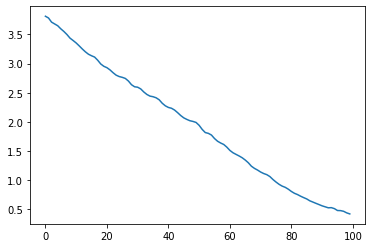

In [45]:
losses = []

for n in range(100):
  print(".",end=" ")
  logs = translator.train_step([inp_batch,targ_batch])
  losses.append(logs["batch_loss"].numpy())

plt.plot(losses)

In [46]:
class BatchLogs(tf.keras.callbacks.Callback):

  def __init__(self,key):
    self.key = key
    self.logs = []
  
  def on_train_batch_end(self,n,logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs("batch_loss")

In [47]:
train_translator = TrainTranslator(
    embedding_dim,
    units,
    input_text_processor,
    output_text_processor
)

train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss = MaskedLoss()
)

In [48]:
translator.fit(dataset,
               epochs=3,
               callbacks=[batch_loss])

Epoch 1/3
1859/1859 [==============================] - 512s 274ms/step - batch_loss: 2.2469
Epoch 2/3
1859/1859 [==============================] - 482s 259ms/step - batch_loss: 1.0545
Epoch 3/3
1859/1859 [==============================] - 479s 258ms/step - batch_loss: 0.8023


Text(0, 0.5, 'CE/token')

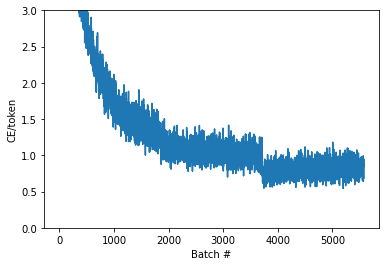

In [49]:
plt.plot(batch_loss.logs)
plt.ylim([0,3])
plt.xlabel("Batch #")
plt.ylabel("CE/token")